In [312]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(font_scale=1, rc={'figure.figsize': (20, 15), "figure.dpi": 100, "savefig.dpi": 100})
sns.set_style("darkgrid")

def warn(*args, **kwargs):
    pass

warnings.warn = warn

# Data Summary and Relationship

This section presents the data and the relationship amongst features. I won't go into much details about the individual time series' since that is not relevant for feature selection.

In [313]:
data = pd.read_csv('data/dataset.csv')
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
data.set_index('date', inplace=True)

A summary of data characteristics if provided below.

In [314]:
stats = data.describe()
stats.loc['skew'] = data.skew().tolist()
stats.loc['kurt'] = data.kurtosis().tolist()
stats

,price,demand,generation_coal,generation_diesel,generation_gas,generation_geo,generation_hydro,generation_wind,generation_wood,cloudcover,dew,humidity,precip,precipcover,solarenergy,temp,winddir,windspeed
count,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,100.569646,20980.063938,3818.922010,12.598392,15193.888944,19944.658071,66339.230811,5321.149008,681.485585,53.922357,9.190771,79.972138,3.099663,8.929866,15.063008,12.865396,201.107166,28.433654
std,70.509956,1862.658455,3664.952344,80.918839,5007.137430,1462.082847,8705.602119,2717.717648,246.182035,16.164405,3.308243,5.548270,3.638905,5.516833,7.754738,3.577091,59.262319,6.743033
min,0.016808,15468.521200,0.000000,0.000000,1753.844000,13436.056323,38516.216832,186.309891,0.000000,9.053024,0.092167,62.852095,0.000000,0.000000,1.308381,4.167548,34.453952,12.451976
25%,55.517461,19698.108575,0.000000,0.000000,11765.739975,19365.412617,60445.832117,3153.795119,661.006500,41.683506,6.759679,76.192119,0.671309,4.637363,7.955679,9.932024,157.785024,23.506482
50%,79.132532,20999.210400,3465.956500,0.000000,14755.118530,20317.658681,66485.942745,4994.229307,778.870000,53.578988,9.032762,80.084393,1.910983,8.410038,14.167190,12.690119,205.337369,27.599750
75%,123.057582,22160.136650,5481.356250,0.000000,18566.258120,20914.497774,72400.887920,7357.672952,834.107500,65.623655,11.661095,83.975798,4.126609,12.396362,21.469732,15.813262,245.807357,32.733911
max,1216.117213,27022.325700,17213.768000,1895.695000,30956.428640,22967.320000,93199.082000,14736.434000,931.137000,97.552333,18.514595,94.739143,36.750307,47.231779,33.975381,21.726524,334.999500,56.459238
skew,2.888983,0.065995,0.988345,11.141217,0.210042,-1.233601,-0.079656,0.427651,-1.723990,0.067310,0.046727,-0.157033,2.665342,0.831280,0.333476,0.071250,-0.239384,0.589065
kurt,23.025562,-0.213533,0.765612,163.854196,-0.026651,1.659903,-0.161182,-0.386208,1.889052,-0.595559,-0.612546,-0.384720,11.308852,1.867591,-1.074538,-0.916966,-0.631905,0.187883


We want to identify the relationship between variables and so let's visualize the correlation matrix.

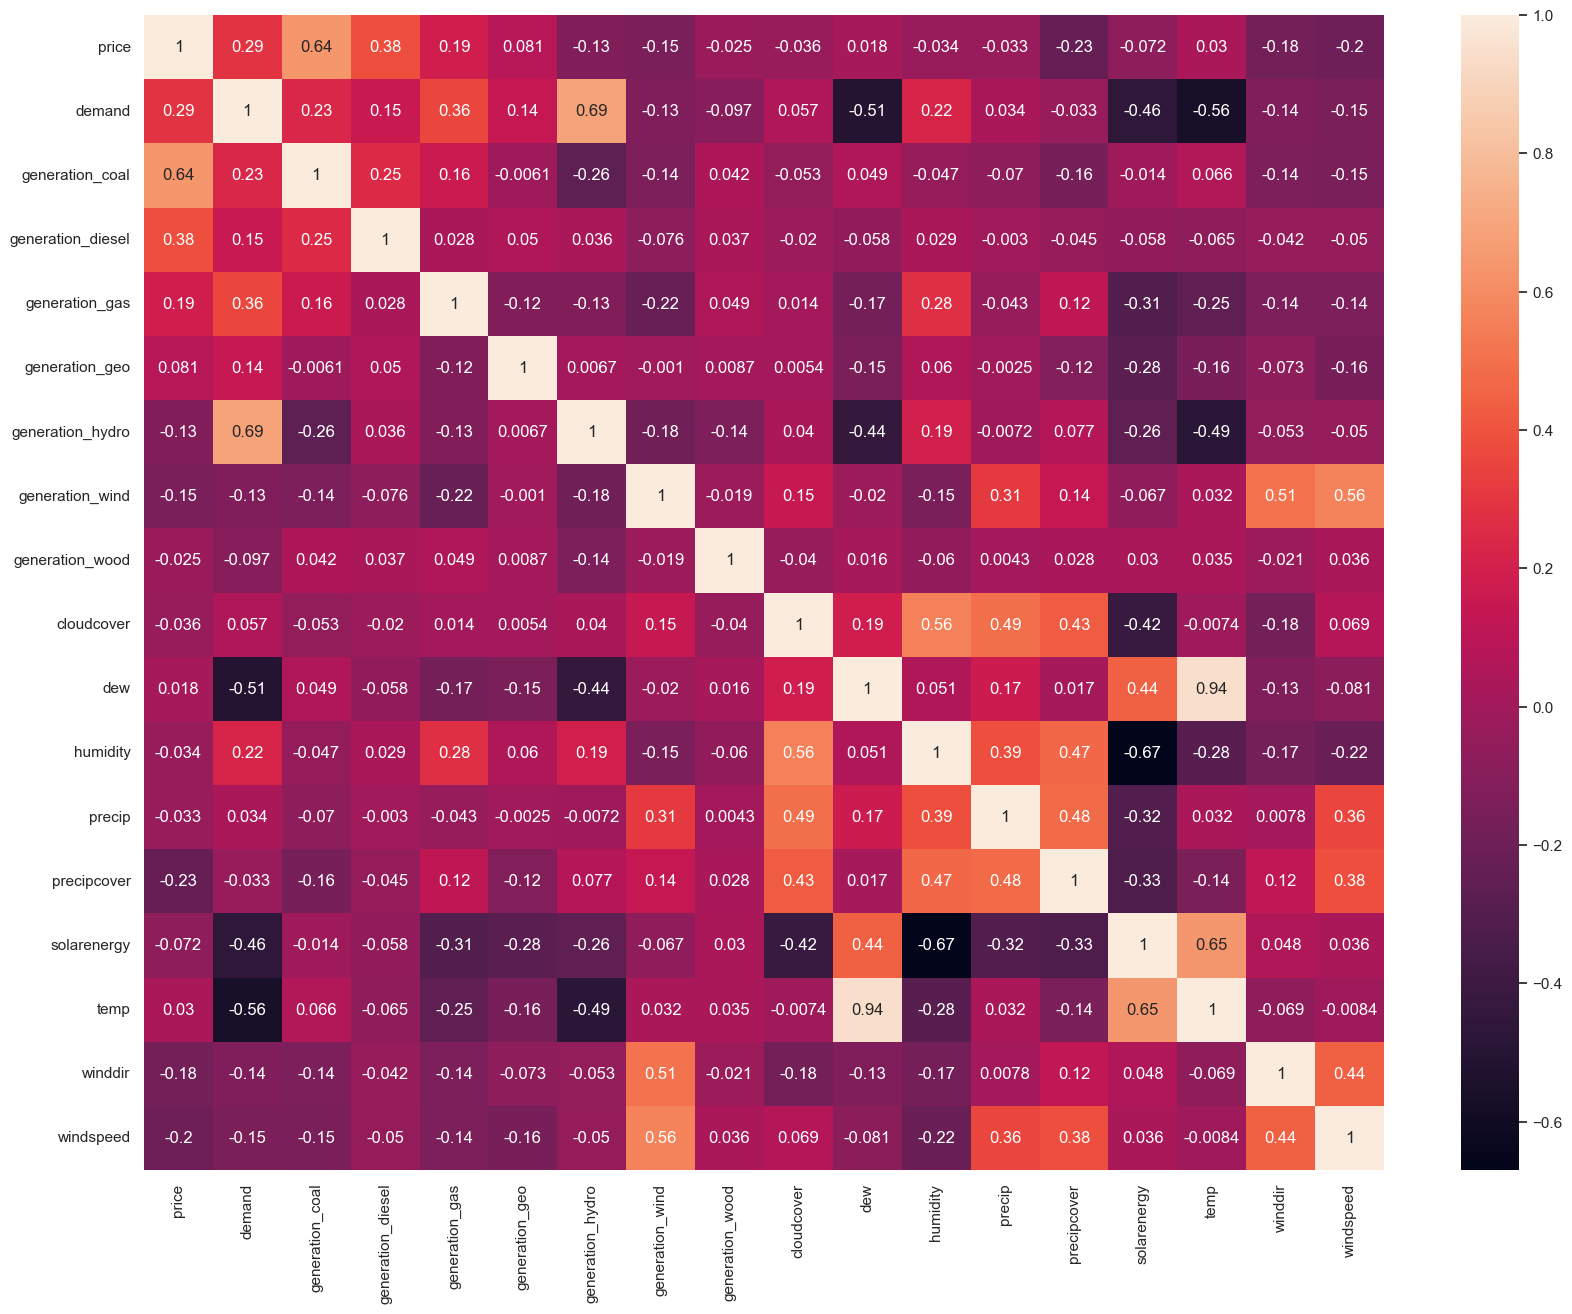

In [315]:
sns.heatmap(data.corr(), annot=True);

Some observations from the correlation heatmap:

- The generation of coal and diesel exhibit a strong positive relationship with price. Non-renewable fuel in New Zealand is largely used during peak hours, and to a greater extent when there is a hydro shortage. Running coal and diesel generators is significantly more expensive than renewable energy so this relationship is not surprising.
- Price and demand are positively correlated. Electricity demand is largely inelastic with respect to most external factors, whereas price is prone to significant deviation with changes in external factors, irrespective of demand.
- Geothermal, gas and hydro generation are positively correlated with demand. They are considered baseline generation sources and are a constant source of electricity. Their generation output throughout the day is ramped up or down depending on demand.
- Demand is negatively correlated with temperature, dew, and solar energy. Winters in New Zealand generally observe higher demand for electricity due to higher usage of heat pumps. Solar energy corresponds to the day-night cycle and demand exhibits an intra-day cycle as well, due to higher industrial and residential usage at different times of the day.
- It is interesting to observe the correlation amongs generation fuels because it explains the role these fuels have in the electricity market. Consider the negative correlation between coal and hydro generation. As New Zealand is a highly renewable electricity market, its dependence on coal is significant only when there is a shortage of hydro fuel. Coal is largely a backup plan, employed only during peak demand hours or when there is a lack of renewable energy.
- Hydro generation does not have a significant relationship with precipitation. However, it is important to note that this correlation is an instantaneous measure. Higher precipitation periods would certainly impact future hydro generation due to higher lake levels and inflows.
- It comes as no surprise that wind generation is positively correlated with wind speeds and direction. Unlike hydro fuel, wind is not storable (yet?) and its generation depends on instantaneous wind levels.
- The significant relationships amongst weather variables are self-explanatory.

# Building Feature Set

We do not need to dwell on these relationships much longer. The primary purpose of this project is feature selection using LASSO. However, feature selection itself is motivated as a tool to obtain robust estimates, to reduce dimensionality for easier computation and analysis, and to avoid over-fitting. 

We are working with time-series data and it is only natural to consider the effect that lagged-values have on future data. One example of this was explained above, with current precipitation having no relationship with current hydro generation, but it certainly would with future generation. For this purpose, we create new features in our dataset which are lagged values of the current features. I have chosen an arbitrary value of 30 time lags for each feature.

## Scaling Data

Before creating a feature set of lagged variables, it would be prudent to transform the data so that they have a similar scale. I don't want to use simple standardization or min-max scaling since many of the features have outliers or extreme ranges. Instead, I will use a power transformation, the Yeo-Johnson method from the ``scikit-learn`` library. The Yeo-Johnson transformation is defined as 

\begin{align*}
y &= ((x + 1)^\lambda - 1) / \lambda \quad \text{for positive data, and} \\
y &= -((-x + 1)^\lambda - 1) / \lambda \quad \text{for negative data.}
\end{align*}

The optimal value for $\lambda$ is chosen through maximum likelihood estimation. Standardization is performed after this transformation.

In [325]:
from sklearn.preprocessing import PowerTransformer

In [326]:
pt = PowerTransformer(method='yeo-johnson')
pt = pt.fit(data)
scaled_data = pt.transform(data)

Let's convert the scaled data into a DataFrame object.

In [327]:
scaled_data = DataFrame(scaled_data)
scaled_data.columns = data.columns.values

In [328]:
scaled_data.describe()

,price,demand,generation_coal,generation_diesel,generation_gas,generation_geo,generation_hydro,generation_wind,generation_wood,cloudcover,dew,humidity,precip,precipcover,solarenergy,temp,winddir,windspeed
count,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03,3.226000e+03
mean,-2.958300e-16,1.040055e-15,-1.312858e-15,3.463269e-15,3.200581e-17,6.308586e-16,3.524081e-16,-1.030381e-16,5.348756e-16,2.362579e-16,1.267155e-16,-4.545513e-16,-1.311206e-16,-6.448482e-18,4.326635e-16,1.640556e-16,-2.763577e-16,-1.489475e-15
std,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00,1.000155e+00
min,-4.587395e+00,-3.075400e+00,-1.492301e+00,-3.315012e-01,-3.032187e+00,-2.380988e+00,-3.070668e+00,-2.724586e+00,-2.562718e+00,-3.048483e+00,-3.003065e+00,-2.847871e+00,-1.749997e+00,-2.298959e+00,-2.614587e+00,-2.687113e+00,-2.546766e+00,-3.353205e+00
25%,-6.469236e-01,-6.810449e-01,-1.492301e+00,-3.315012e-01,-6.626148e-01,-6.340377e-01,-6.852312e-01,-7.393837e-01,-1.743265e-01,-7.421281e-01,-7.199065e-01,-6.998059e-01,-8.335105e-01,-7.148573e-01,-8.905395e-01,-8.038973e-01,-7.555389e-01,-6.929263e-01
50%,-1.263574e-01,2.352514e-02,4.292914e-01,-3.315012e-01,-5.476060e-02,9.444954e-02,4.334628e-03,5.687223e-05,3.858264e-01,4.812249e-03,-2.442498e-02,-8.772409e-03,2.029890e-02,6.097231e-02,4.579159e-02,-1.128432e-02,4.040850e-02,-1.158467e-02
75%,5.799756e-01,6.412701e-01,7.022042e-01,-3.315012e-01,6.876609e-01,6.621528e-01,6.912251e-01,7.916354e-01,6.570359e-01,7.332033e-01,7.536032e-01,7.107265e-01,7.657227e-01,7.158453e-01,8.713431e-01,8.330903e-01,7.487888e-01,7.150375e-01
max,5.497203e+00,3.131201e+00,1.541165e+00,3.037264e+00,2.932352e+00,3.477265e+00,3.187376e+00,2.727881e+00,1.145826e+00,2.566698e+00,2.690204e+00,2.848176e+00,2.630195e+00,4.254408e+00,1.953981e+00,2.319171e+00,2.392323e+00,3.047102e+00


All variables are in similar ranges now.

## Building Lagged Features

The function below will generate the specified number of lagged features for the input data.

In [329]:
def build_lags(data, n_lags=1):
    df = DataFrame(data)
    cols, names = list(), list()
    col_names = list(data)

    for i in range(n_lags, 0, -1):
        cols.append(df.shift(i))
        names += [('%s (t-%d)' % (j, i)) for j in col_names]
        
    cols.append(df.shift(-i))
    names += [('%s (t)' % (j)) for j in col_names]

    agg = concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    
    return agg

In [330]:
num_lags = 30
lag_data = build_lags(scaled_data, n_lags=num_lags)

In [331]:
lag_data

,price (t-30),demand (t-30),generation_coal (t-30),generation_diesel (t-30),generation_gas (t-30),generation_geo (t-30),generation_hydro (t-30),generation_wind (t-30),generation_wood (t-30),cloudcover (t-30),...,generation_wood (t),cloudcover (t),dew (t),humidity (t),precip (t),precipcover (t),solarenergy (t),temp (t),winddir (t),windspeed (t)
30,-1.935973,-2.699566,-1.492301,-0.331501,-1.405115,-1.632013,-1.090615,-0.045802,0.692602,0.455447,...,0.944739,-0.887582,0.714194,-0.746612,-0.853114,-0.653830,1.240020,0.905486,-0.678503,0.409696
31,-2.199742,-3.075400,-1.492301,-0.331501,-1.354476,-1.649098,-1.501784,0.890079,0.247940,-0.103555,...,0.842632,-1.746522,0.480167,-1.414070,-1.537971,-1.952905,1.522047,0.952371,-0.700744,-0.526696
32,-1.585592,-2.390848,-1.492301,-0.331501,-1.334000,-1.386262,-0.912121,0.988679,0.489499,0.125156,...,0.851931,-2.546542,0.738029,-1.232479,-1.749997,-2.298959,1.616088,1.143326,-0.828264,-1.509169
33,-1.511914,-2.223537,-1.492301,-0.331501,-1.345057,-0.996040,-0.806616,0.217833,0.215442,-0.013985,...,0.397324,-1.428696,0.948421,-0.770893,-1.449337,-1.464085,1.539882,1.152467,-0.224679,0.009816
34,-1.555152,-2.568987,-1.492301,-0.331501,-1.408213,-1.327804,-1.072888,1.161545,0.564996,-0.964508,...,0.315020,-0.187213,0.733743,-0.875468,-1.084466,-0.029846,1.097811,0.970847,0.504071,0.126262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220,-1.475493,-0.287565,0.432956,-0.331501,-2.841415,1.360141,0.356515,0.989228,-0.035716,1.831061,...,-0.396474,1.096734,0.374680,0.115505,0.056417,-0.986612,0.197686,0.317488,-0.145757,-0.789833
3221,-0.701551,0.574425,-0.669224,-0.331501,-1.245795,0.044232,1.685796,-0.901573,0.168547,1.312947,...,0.314241,1.438221,0.992325,0.704445,1.292826,-0.254784,-0.054687,0.727838,-0.572586,-0.086211
3222,-0.786450,0.617746,-1.492301,-0.331501,-1.257842,-0.240668,1.479869,-0.059724,0.382001,1.665379,...,0.675005,1.878619,1.551155,0.839849,1.535014,0.418940,-0.340604,1.208359,-0.063732,0.400041
3223,-1.077248,0.725256,-1.492301,-0.331501,-1.429012,0.903717,0.931206,1.313067,0.203727,2.095924,...,0.559958,1.551300,1.307750,0.710769,2.374429,1.227370,-0.375796,1.063146,0.157725,0.238021


Perfect! Now I will specify my target vector and feature set. 

The target variable is `price (t)`.

For features, we want to use all variables but only as recent as time `t-1`. I don't want to include variables at time `t`. In practice, this would really depend on the order in which data is obtained in real time. But I'm keeping it simple.

In [332]:
y = lag_data[['price (t)']]
y.shape

(3195, 1)

In [333]:
X = lag_data.loc[:, :'windspeed (t-1)']
X.shape

(3195, 540)

So our feature set contains 540 features. Now, we can use LASSO to perform variable selection on our feature set.

# Feature Selection using LASSO

The LASSO (least absolute shrinkage and selection operator) is a type of regularization method that is used to improve the predictive performance of linear regression models. It works by adding a penalty term to the objective function that is being optimized. The penalty term is defined as the sum of the absolute values of the model coefficients, multiplied by a hyperparameter called the regularization parameter, denoted $\alpha$. The objective function for LASSO is defined as:

\begin{align*}
\min_{\boldsymbol{\beta}} \frac{1}{n} \sum_{i=1}^n (y_i - \boldsymbol{x_i}^T \boldsymbol{\beta})^2 + \alpha \sum_{j=1}^p |\beta_j|,
\end{align*}

where $\boldsymbol{\beta}$ is the vector of coefficients, $n$ is the number of samples, $\boldsymbol{x_i}$ is the feature vector for the $i$-th sample, $y_i$ is the target variable for the $i$-th sample, $p$ is the number of features, and $\alpha$ is the regularization parameter.

The regularization strength determines how much the coefficients of the model should be penalized. When the regularization strength is set to a high value, the coefficients of the model will be strongly penalized, which will result in a model with fewer non-zero coefficients (i.e., a model with fewer features). When the regularization strength is set to a low value, the coefficients of the model will be less heavily penalized, which will result in a model with more non-zero coefficients (i.e., a model with more features).

The goal of LASSO regularization is to balance the trade-off between model complexity and model performance. By penalizing the coefficients of the model, LASSO can help to prevent overfitting and improve the generalization performance of the model. In this way, it serves as a feature selection technique.

Firstly, I will build the cross-validation sets for LASSO estimation. It's important to remember that the features are time-series' and cross-validation must preserve the sequential nature of our data. The `scikit-learn` library has a module just for this.

In [334]:
from sklearn.model_selection import TimeSeriesSplit

I want a 50-fold cross-validation scheme. This seems like a large number, but my idea is to assess how many times each feature is chosen (not reduced to 0) out of the 50 cross-validation sets.

In [335]:
ts_cv = TimeSeriesSplit(n_splits=50, gap=0)
splits = list(ts_cv.split(X, y))

## Evaluate LASSO with Cross-Validation

In [336]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from numpy import arange

I use a grid search algorithm to identify the optimal regularization parameter $\alpha$ for LASSO. I only search for $\alpha$ values between 0 and 0.1, since I already know the optimal solution lies in this range. In practice, it may be necessary to increase the upper bound of the search range. I use the mean absolute error as the scoring criteria.

In [ ]:
model = Lasso()
grid = dict()
grid['alpha'] = arange(0, 0.1, 0.001)
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=ts_cv, verbose=3)
results = search.fit(X, y)

In [349]:
best_alpha = results.best_estimator_.alpha
best_score = results.best_score_

print("Best alpha: {a}".format(a=best_alpha))
print("Best score: {s}".format(s=best_score))

Best alpha: 0.014
Best score: -0.4010936812443031


Let's visualize the change in scores with respect to changes in $\alpha$.

In [354]:
alpha_values = grid['alpha'].tolist()
scores = -np.array(results.cv_results_['mean_test_score'].tolist())

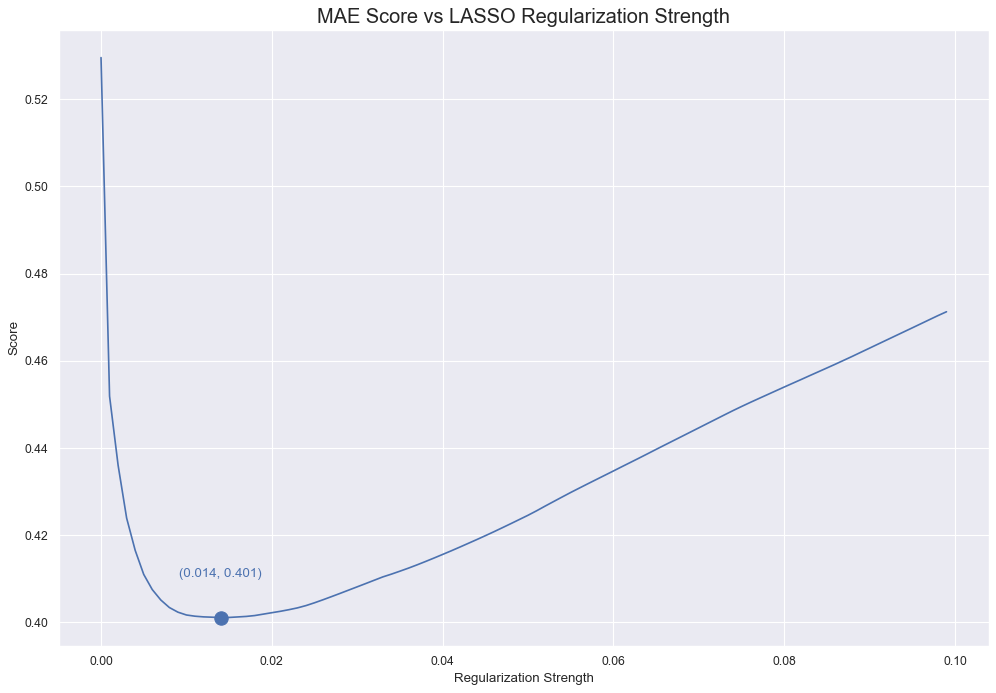

In [371]:
sns.set(font_scale=1, rc={'figure.figsize': (15, 10), "figure.dpi": 80,
                          "savefig.dpi": 80})

sns.lineplot(alpha_values, scores)

plt.plot(best_alpha, -best_score, marker="o", color='b', markersize='12')
plt.text(best_alpha, -best_score + 0.01,
         "(" + str(np.round(best_alpha, decimals=3)) + ", " +
         str(np.round(-best_score, decimals=3)) + ")", fontsize=12,
         horizontalalignment='center', verticalalignment='center', color='b')

plt.title('MAE Score vs LASSO Regularization Strength', fontdict={'fontsize': 18})
plt.xlabel('Regularization Strength')
plt.ylabel('Score');

It is clear from this figure that the OLS estimate (when $\alpha = 0$) is much worse than the LASSO optimized estimate. The scores shown here are mean scores from each of the 50 cross-validation sets.

## Identifying LASSO-Suggested Features

Now let's identify which features are actually chosen by LASSO with the optimal regularization strength. First, we build this LASSO model.

In [374]:
model = Lasso(alpha=best_alpha)

Now I create a dictionary of our feature set to keep a count of how many times they are included in the model in all the cross-validation sets.

In [375]:
params = {}
for p in list(X):
    params[p] = 0

for i in range(ts_cv.n_splits):
    X_train = X.iloc[splits[i][0]]
    y_train = y.iloc[splits[i][0]]

    model.fit(X_train, y_train)

    relevant_params_index = [i for i, e in enumerate(list(model.coef_)) if e != 0]
    relevant_params = [list(X)[i] for i in relevant_params_index]

    for p in relevant_params:
        params[p] += 1

Let's visualize this result nicely. I will use a heatmap for this.

In [378]:
params_list = list(params.items())
param_values = [x[1] for x in params_list]
params_table = {}
cols = list(data)


lag = 0
for p in range(1, num_lags+1):
    params_table[num_lags-p+1] = param_values[lag:lag+len(cols)]
    lag += len(cols)

count_df = pd.DataFrame(params_table, index=cols).add_prefix(
    '(t-').add_suffix(')')
count_df = count_df.iloc[:, ::-1]

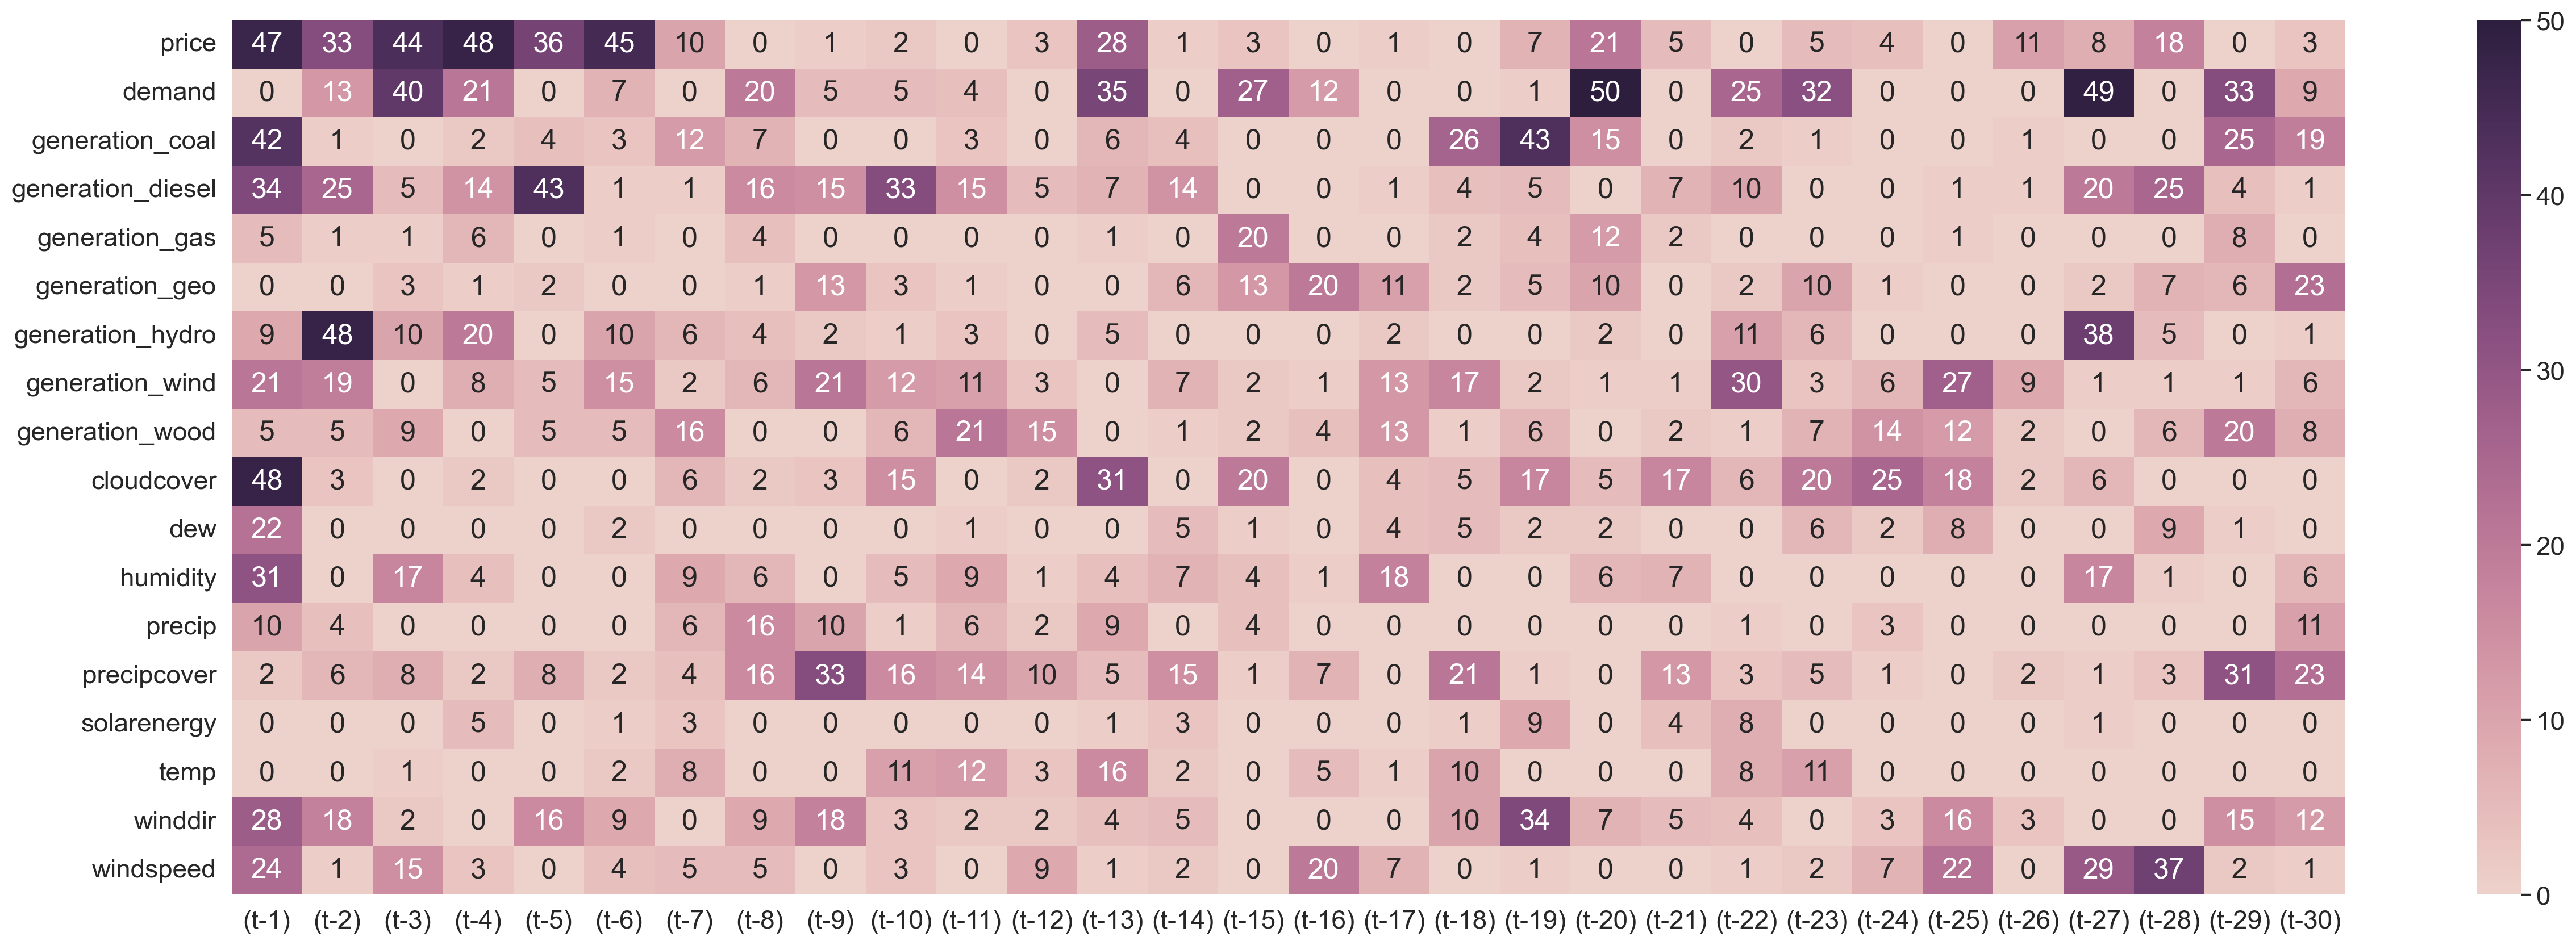

In [379]:
sns.set(font_scale=1.5, rc={'figure.figsize': (30, 10), "figure.dpi": 200,
                            "savefig.dpi": 200})

sns.heatmap(count_df, annot=True, cmap=sns.cubehelix_palette(as_cmap=True));

The heatmap above shows a count of every feature and its lag representing how many times it appears as a relevant feature out of 50 cross-validation sets. Some comments on the results:

- Surprisingly, `demand (t-20)` is the only feature to appear all 50 times, and `demand (t-27)` appears 49 times, the second-highest number. It is clear that these lags represent the weekly seasonality in electricity prices. Certain lags of a feature overwhelm the LASSO selection and diminish other lags completely, which is likely why `demand (t-1)` does not appear even once.
- Price lags are mostly relevant up to `(t-6)` and then appear again around the weekly cycles at `(t-13)` and `(t-20)`.
- In regards to generation variables, `gas` and `geothermal` features do not appear often, wheareas `coal`, `diesel` and `hydro` are highly prevalent. It is interesting to note that a lot of generation variables at lags beyond `(t-20)` are still relevant.
- `solarenergy`, `dew` and `temp` are generally disregarded, likely due to their high correlation with `demand`.
- `precip` is also generally disregarded, possibly because `cloudcover` and `precipcover` take higher precedence.

Using this information, we can select a subset of features to include for modeling purposes. We can do this by either setting a threshold of occurrences or by using the proportion of occurrences as a weight for each lagged feature.